Cell 0 — Plot setup

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")


Cell 1 — Imports

In [4]:
import pandas as pd
import numpy as np

# Week 8/9 linear regression & metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics


Cell 2 — Load CSVs

In [5]:
df1 = pd.read_csv("dataset1.csv")   # bat-level (Investigation A)
df2 = pd.read_csv("dataset2.csv")   # 30-min windows (Investigation B)
print("df1:", df1.shape, " df2:", df2.shape)


df1: (907, 12)  df2: (2123, 7)


Cell 3 — Quick peek

In [6]:
display(df1.head(3)); display(df2.head(3))
print("df1 cols:", list(df1.columns))
print("df2 cols:", list(df2.columns))


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.0,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.0,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.0,0.0,0


df1 cols: ['start_time', 'bat_landing_to_food', 'habit', 'rat_period_start', 'rat_period_end', 'seconds_after_rat_arrival', 'risk', 'reward', 'month', 'sunset_time', 'hours_after_sunset', 'season']
df2 cols: ['time', 'month', 'hours_after_sunset', 'bat_landing_number', 'food_availability', 'rat_minutes', 'rat_arrival_number']


Cleaning & features
Cell 4A — Types (df1)

In [7]:
for c in ["bat_landing_to_food","seconds_after_rat_arrival","risk","reward","hours_after_sunset"]:
    if c in df1.columns: df1[c] = pd.to_numeric(df1[c], errors="coerce")
for c in ["risk","reward"]:
    if c in df1.columns: df1[c] = df1[c].round().clip(0,1).astype("Int64")
for c in ["season","month"]:
    if c in df1.columns: df1[c] = df1[c].astype("category")


Cell 4B — Types (df2)

In [8]:
for c in ["hours_after_sunset","bat_landing_number","food_availability","rat_minutes","rat_arrival_number"]:
    if c in df2.columns: df2[c] = pd.to_numeric(df2[c], errors="coerce")
if "month" in df2.columns: df2["month"] = df2["month"].astype("category")


Cell 5 — Map season onto df2 via month (mode per month)

In [9]:
if {"month","season"}.issubset(df1.columns):
    m2s = (df1.dropna(subset=["month","season"])
             .groupby("month")["season"]
             .agg(lambda s: s.mode().iat[0] if not s.mode().empty else np.nan))
    df2["season"] = df2["month"].map(m2s).astype("category")
else:
    df2["season"] = pd.NA


C:\Users\timsi\AppData\Local\Temp\ipykernel_30896\1338664508.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("month")["season"]


In [10]:
df2["season"] = df2["season"].fillna(df2["season"].mode().iat[0]).astype("int64").astype("category")


Cell 6 — Hour bins + rat_present

In [11]:
def hour_bin(x):
    if pd.isna(x): return np.nan
    return "0-1h" if x<1 else "1-2h" if x<2 else "2-3h" if x<3 else "3h+"

if "hours_after_sunset" in df1.columns: df1["hrs_bin"] = df1["hours_after_sunset"].apply(hour_bin).astype("category")
if "hours_after_sunset" in df2.columns: df2["hrs_bin"] = df2["hours_after_sunset"].apply(hour_bin).astype("category")
if "rat_minutes" in df2.columns: df2["rat_present"] = (df2["rat_minutes"]>0).astype(int)


Quick EDA & season summary (useful for Investigation B story)

Cell 7 — Risk counts (A)

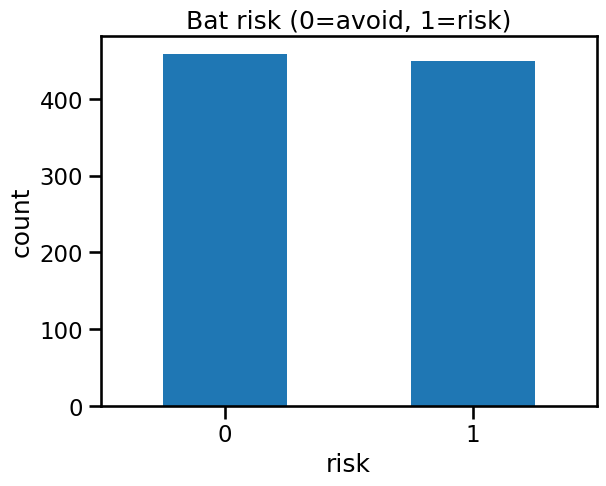

In [12]:
if "risk" in df1.columns:
    ax = df1["risk"].value_counts(dropna=False).sort_index().plot(kind="bar", rot=0)
    ax.set_title("Bat risk (0=avoid, 1=risk)"); ax.set_xlabel("risk"); ax.set_ylabel("count")
    plt.show()


Cell 8 — Scatter (B)

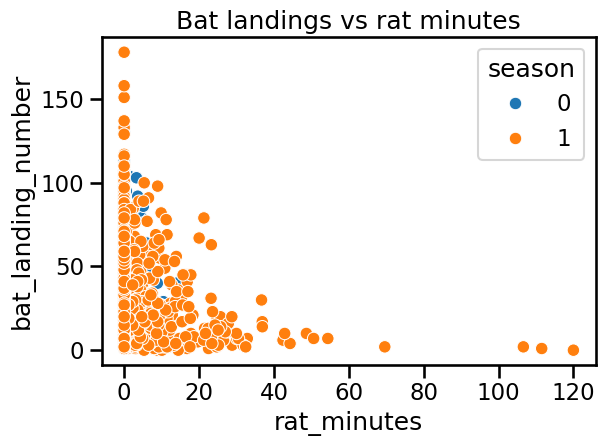

In [13]:
if {"rat_minutes","bat_landing_number"}.issubset(df2.columns):
    sns.scatterplot(data=df2, x="rat_minutes", y="bat_landing_number", hue=df2.get("season"))
    plt.title("Bat landings vs rat minutes"); plt.tight_layout(); plt.show()


Cell 9 — Boxplot bat landings by season (B)

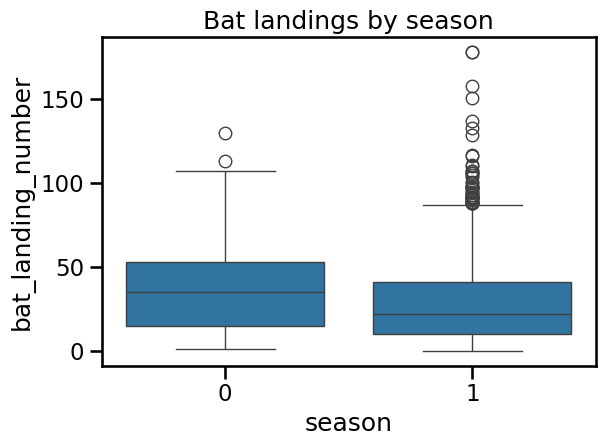

In [14]:
sns.boxplot(data=df2.dropna(subset=["season","bat_landing_number"]), x="season", y="bat_landing_number")
plt.title("Bat landings by season"); plt.tight_layout(); plt.show()


Cell 10A — Season-level summary (table)

In [15]:
season_summary = (df2.groupby("season", observed=True)
    .agg(
        bat_mean=("bat_landing_number","mean"),
        bat_median=("bat_landing_number","median"),
        rat_mean=("rat_minutes","mean"),
        rat_present_rate=("rat_minutes", lambda x: (x>0).mean()),
        food_mean=("food_availability","mean")
    ).round(2)
)
display(season_summary)


,bat_mean,bat_median,rat_mean,rat_present_rate,food_mean
season,,,,,
0,36.76,35.0,0.47,0.15,2.34
1,28.77,22.0,3.07,0.33,2.52


Cell 10B — Quick visuals (rat & food by season)

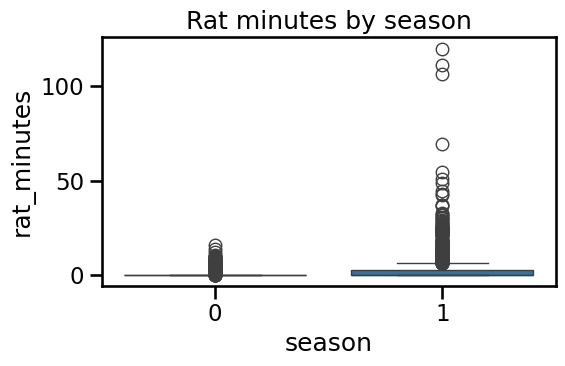

In [16]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df2, x="season", y="rat_minutes")
plt.title("Rat minutes by season"); plt.tight_layout(); plt.show()

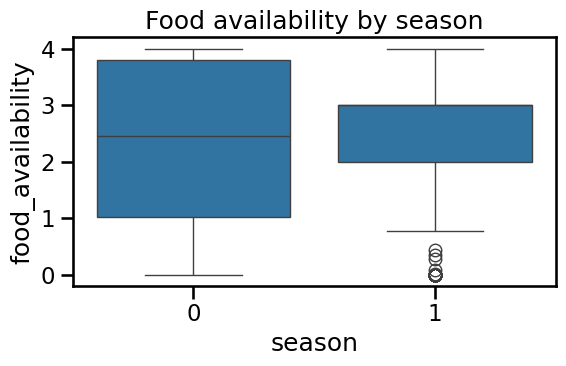

In [17]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df2, x="season", y="food_availability")
plt.title("Food availability by season"); plt.tight_layout(); plt.show()

Linear Regression — helpers (Week 8/9 style)

Cell 11 — Metric helpers + baseline

In [18]:
def eval_lr(y_true, y_pred):
    mae  = metrics.mean_absolute_error(y_true, y_pred)
    mse  = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    nrmse = rmse / (y_true.max() - y_true.min())
    r2   = metrics.r2_score(y_true, y_pred)
    print(f"MAE={mae:.2f} | MSE={mse:.2f} | RMSE={rmse:.2f} | NRMSE={nrmse:.3f} | R^2={r2:.3f}")


In [19]:
def baseline_mean(y_train, y_test):
    return np.repeat(np.mean(y_train), len(y_test))

Cell 11B — LR diagnostic plots (helper)

In [20]:
# Cell 11B — LR diagnostic plots (helper)
def plot_lr_diagnostics(y_true, y_pred, title_prefix):
    # Predicted vs Actual
    plt.figure(figsize=(6,4))
    plt.scatter(y_true, y_pred, alpha=0.7)
    lo, hi = float(np.min(y_true)), float(np.max(y_true))
    plt.plot([lo, hi], [lo, hi], "r--", linewidth=1)
    plt.xlabel("Actual"); plt.ylabel("Predicted")
    plt.title(f"{title_prefix} — Predicted vs Actual")
    plt.tight_layout(); plt.show()

    # Residuals histogram
    resid = y_true - y_pred
    plt.figure(figsize=(6,4))
    sns.histplot(resid, bins=20, kde=True)
    plt.xlabel("Residual"); plt.title(f"{title_prefix} — Residuals")
    plt.tight_layout(); plt.show()


Investigation A — Linear Regression

Goal: model time to food (bat_landing_to_food) from rat context + timing controls.

Cell 12 — Build rat context on df1 (merge from df2)

In [21]:
keys = [k for k in ["season","hrs_bin"] if k in df2.columns]
A_df = df1.copy()

In [22]:
if keys:
    rat_ctx = (df2.groupby(keys, observed=True)
                 .agg(rat_present_rate=("rat_minutes", lambda x: (x>0).mean()),
                      rat_minutes_mean=("rat_minutes","mean"),
                      food_mean=("food_availability","mean"))
                 .reset_index())
    A_df = A_df.merge(rat_ctx, on=keys, how="left")
else:
    for c in ["rat_present_rate","rat_minutes_mean","food_mean"]:
        A_df[c] = np.nan

Cell 13 — Prepare X/y (A)

In [23]:
A_use = A_df.dropna(subset=["bat_landing_to_food"]).copy()
y_A = A_use["bat_landing_to_food"].to_numpy()

In [24]:
num_cols = [c for c in [
    "rat_present_rate","rat_minutes_mean","food_mean",
    "hours_after_sunset","seconds_after_rat_arrival",
    "risk","reward"
] if c in A_use.columns]
X_num = A_use[num_cols].fillna(0)

In [25]:
cat_cols = [c for c in ["season","hrs_bin"] if c in A_use.columns]
X_cat = pd.get_dummies(A_use[cat_cols], drop_first=True) if cat_cols else pd.DataFrame(index=A_use.index)

In [26]:
X_A = pd.concat([X_num, X_cat], axis=1)
print("A shapes -> X:", X_A.shape, " y:", y_A.shape)

A shapes -> X: (907, 11)  y: (907,)


Cell 14 — Train/test LR (A) + metrics + baseline

In [27]:
XA_tr, XA_te, yA_tr, yA_te = train_test_split(X_A, y_A, test_size=0.4, random_state=0)

lr_A = LinearRegression().fit(XA_tr, yA_tr)
yA_pred = lr_A.predict(XA_te)

In [28]:
print("A — intercept:", lr_A.intercept_)
coef_A = pd.Series(lr_A.coef_, index=X_A.columns).sort_values(key=np.abs, ascending=False)
display(coef_A.head(10))

A — intercept: -368.76986474126977


rat_present_rate      663.042904
hrs_bin_3h+           130.566844
food_mean              83.513381
rat_minutes_mean      -41.644389
season_1              -20.804285
risk                   17.058741
hrs_bin_1-2h           -9.923406
reward                  9.751935
hrs_bin_2-3h           -2.598665
hours_after_sunset     -0.267663
dtype: float64

In [29]:
print("A — Linear Regression performance:")
eval_lr(yA_te, yA_pred)

A — Linear Regression performance:
MAE=11.95 | MSE=472.78 | RMSE=21.74 | NRMSE=0.112 | R^2=0.019


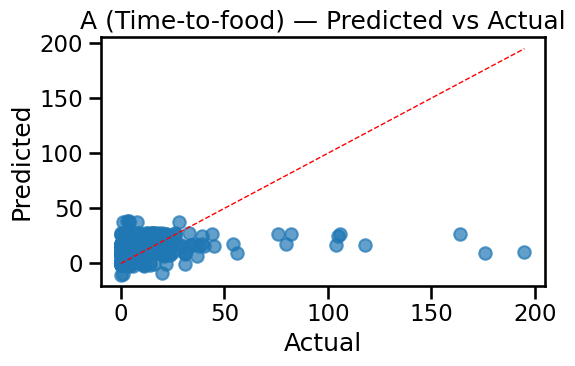

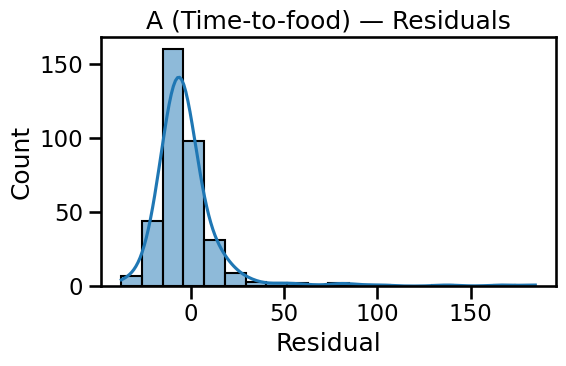

In [30]:
plot_lr_diagnostics(yA_te, yA_pred, "A (Time-to-food)")

In [31]:
print("A — Baseline (mean) performance:")
yA_pred_base = baseline_mean(yA_tr, yA_te)
eval_lr(yA_te, yA_pred_base)

A — Baseline (mean) performance:
MAE=12.29 | MSE=484.07 | RMSE=22.00 | NRMSE=0.113 | R^2=-0.005


Investigation B — Linear Regression per season

Goal: compare winter vs spring models on bat_landing_number.

Cell 15A — prep helper

In [32]:
def prep_B_Xy(season_value):
    S = df2[df2["season"] == season_value].dropna(subset=["bat_landing_number"]).copy()
    if S.empty:
        print(f"No rows for season={season_value}")
        return None, None

    y = S["bat_landing_number"].to_numpy()
    num_cols = [c for c in ["rat_minutes", "food_availability", "hours_after_sunset", "rat_arrival_number"] if c in S.columns]
    X_num = S[num_cols].fillna(0)
    X_cat = pd.get_dummies(S[["hrs_bin"]], drop_first=True) if "hrs_bin" in S.columns else pd.DataFrame(index=S.index)
    X = pd.concat([X_num, X_cat], axis=1)
    return X, y


Cell 15B — original logic (train/test, fit, metrics, baseline)

In [36]:
def run_B_lr_for_season(season_value):
    X, y = prep_B_Xy(season_value)
    if X is None:
        return None

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.4, random_state=0)
    lr = LinearRegression().fit(X_tr, y_tr)
    y_pred = lr.predict(X_te)

    print(f"\nSeason {season_value} — intercept:", lr.intercept_)
    coefs = pd.Series(lr.coef_, index=X.columns).sort_values(key=np.abs, ascending=False)
    display(coefs.head(10))

    print(f"Season {season_value} — Linear Regression performance:")
    eval_lr(y_te, y_pred)

    plot_lr_diagnostics(y_te, y_pred, f"B Season {season_value}")

    print(f"Season {season_value} — Baseline (mean) performance:")
    y_pred_base = baseline_mean(y_tr, y_te)
    eval_lr(y_te, y_pred_base)
    return coefs


Cell 16 — Fit both seasons & compare coefficients


Season 0 — intercept: 19.24407850831175


hrs_bin_3h+           70.912971
hrs_bin_2-3h          50.740182
hrs_bin_1-2h          28.021481
hours_after_sunset    -6.268807
food_availability     -2.017762
rat_arrival_number     1.996343
rat_minutes           -1.091149
dtype: float64

Season 0 — Linear Regression performance:
MAE=14.08 | MSE=346.58 | RMSE=18.62 | NRMSE=0.144 | R^2=0.426


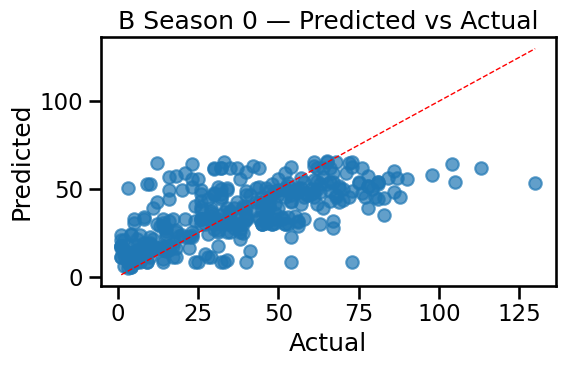

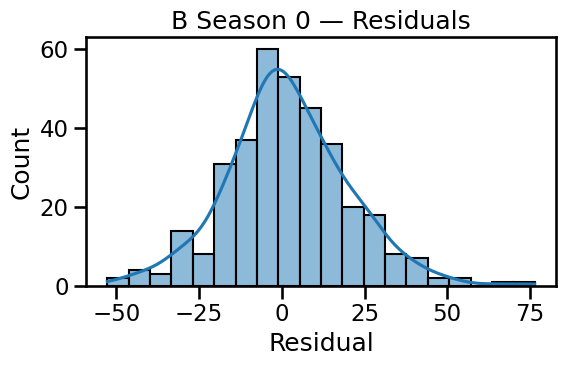

Season 0 — Baseline (mean) performance:
MAE=20.27 | MSE=605.95 | RMSE=24.62 | NRMSE=0.191 | R^2=-0.003

Season 1 — intercept: 20.33750713156503


hrs_bin_3h+           59.637445
hrs_bin_2-3h          35.106899
hrs_bin_1-2h          18.393621
hours_after_sunset    -6.039905
rat_arrival_number    -1.854811
food_availability     -0.972214
rat_minutes           -0.159737
dtype: float64

Season 1 — Linear Regression performance:
MAE=14.84 | MSE=429.39 | RMSE=20.72 | NRMSE=0.131 | R^2=0.397


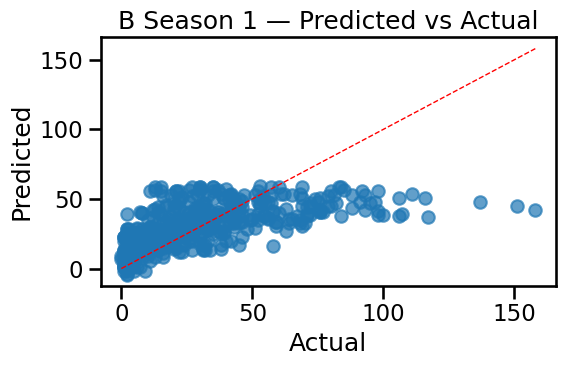

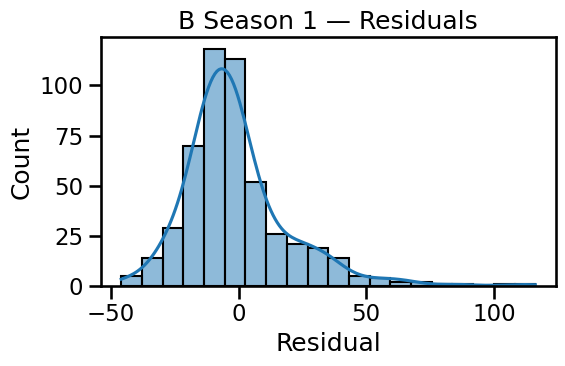

Season 1 — Baseline (mean) performance:
MAE=20.67 | MSE=712.34 | RMSE=26.69 | NRMSE=0.169 | R^2=-0.001


In [37]:
coefs_W = run_B_lr_for_season(0)   # Winter (0)
coefs_S = run_B_lr_for_season(1)   # Spring (1)


In [35]:

if (coefs_W is not None) and (coefs_S is not None):
    top = pd.concat([coefs_W.abs(), coefs_S.abs()], axis=1)
    top.columns = ["|coef|_winter","|coef|_spring"]
    top = top.fillna(0).sum(axis=1).sort_values(ascending=False).head(8)
    comp = pd.DataFrame({
        "winter_coef": coefs_W.reindex(top.index),
        "spring_coef": coefs_S.reindex(top.index)
    }).round(3)
    display(comp)

,winter_coef,spring_coef
hrs_bin_3h+,70.913,59.637
hrs_bin_2-3h,50.740,35.107
hrs_bin_1-2h,28.021,18.394
hours_after_sunset,-6.269,-6.040
rat_arrival_number,1.996,-1.855
food_availability,-2.018,-0.972
rat_minutes,-1.091,-0.160
